![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Optimization Methods </center>
### <center> Update Rules (SGDM & Adam)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_OptimizationMethods/MainUpdateRules_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/03_OptimizationMethods/UpdateRulesAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- What we have so far:
from UpdateRulesAux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Dataset, Accuracy

### Get Fashion MNIST dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
mX.shape, vY.shape

((60000, 784), (60000,))

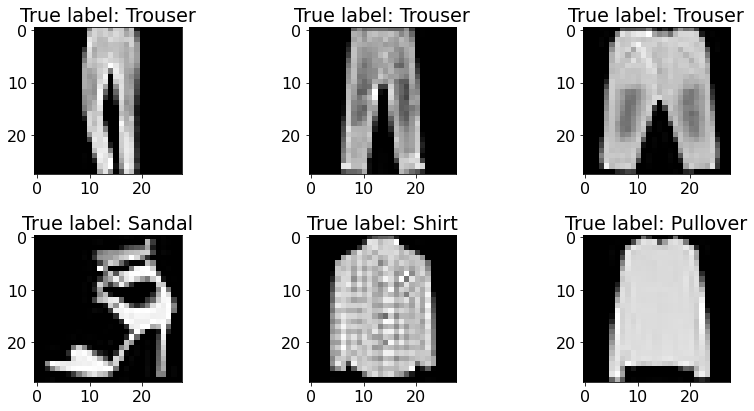

In [7]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12, 6))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vY[idx]]}')
    
plt.tight_layout()
plt.show()

####  Normalize data:

In [8]:
vMean = mX.mean(0)
vStd  = mX.std (0)
mX    = (mX - vMean) / vStd

####  Split to train and validation:

In [9]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(
mTrainX.shape, 
vTrainY.shape, 
mValX  .shape,  
vValY  .shape
)

((55000, 784), (55000,), (5000, 784), (5000,))

#### Data loaders:

In [10]:
batchSize = 256
oTrainSet = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet   = Dataset(mValX.T,   vValY,   batchSize)

### A basic optimizer (only SGD):
$$\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}-\mu\nabla_{\boldsymbol{p}}L$$

In [11]:
#-- Basic gradient descent update rule:
class Sgd:
    def __init__(self, lr=1e-3):
        self.lr = lr
        
    def Step(self, mP, mDp, dState={}):
        mP -= self.lr * mDp
        return mP, dState

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Optimizer:
    def __init__(self, oUpdateRule):
        self.oUpdateRule = oUpdateRule #-- SGD, SGDM, ADAM
        self.dStates     = {}
            
    def Step(self, oModel, lr=None):
        if lr is not None:
            self.oUpdateRule.lr = lr
        
        for ii, oLayer in enumerate(oModel.lLayers):
            for sParamKey in oLayer.dGrads:
                #-- Get param, gradient and history:
                mP       = oLayer.dParams[sParamKey]
                mDp      = oLayer.dGrads [sParamKey]
                sParamID = f'{ii}_{sParamKey}'
                dState   = self.dStates.get(sParamID, {})
                
                #-- Apply step:
                mP, dState = self.oUpdateRule.Step(mP, mDp, dState)
                
                #-- Set param and hisoty:
                oLayer.dParams[sParamKey] = mP
                self.dStates  [sParamID ] = dState

### Epoch with an optimizer:
* We merge `TrainEpoch` and `ValidationEpoch` into a single function.  
* `bTrain` indicates whether we train or validate.

In [12]:
import time
    
def Epoch(oModel, oData, oOptim=None, bTrain=True):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oData):
        
        Nb     = len(vY)
        count += Nb
        
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        if bTrain == True:
            oModel.Backward(mDz) #-- backward
            oOptim.Step(oModel)  #-- update parameters
            
        epochLoss += Nb * loss
        epochAcc  += Nb * Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:2.6f}', end='')
    
    print('', end='\r')
    epochLoss /= count
    epochAcc  /= count
    
    return epochLoss, epochAcc

In [13]:
def TrainModel(oModel, oTrainData, oValData, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    for epoch in range(nEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainData, oOptim, bTrain=True )
        valLoss,   valAcc   = Epoch(oModel, oValData,           bTrain=False)
        epochTime           = time.time() - startTime
        
        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,  end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,  end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',  end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',  end='')
        print(' | epoch time: '     f'{epochTime:3.3f} |'       )
        
        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        
    return vTrainLoss, vTrainAcc, vValLoss, vValAcc

####  Define a model:

In [14]:
def GetModel():
    oModel = SequentialModel([
        LinearLayer(784, 350), ReLULayer(),
        LinearLayer(350, 250), ReLULayer(),
        LinearLayer(250, 150), ReLULayer(),
        LinearLayer(150, 50 ), ReLULayer(),
        LinearLayer(50,  10 ),
    ])
    
    return oModel

### Train the model with SGD:

In [15]:
oModel  = GetModel()
oOptim  = Optimizer(Sgd(lr=2e-2))
nEpochs = 10

TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim);

Epoch 000: | Train loss: 0.70476 | Val loss: 0.50611 | Train Accuracy: 0.7586 | Val Accuracy: 0.8164 | epoch time: 3.988 |
Epoch 001: | Train loss: 0.45451 | Val loss: 0.42748 | Train Accuracy: 0.8366 | Val Accuracy: 0.8426 | epoch time: 3.480 |
Epoch 002: | Train loss: 0.40163 | Val loss: 0.39856 | Train Accuracy: 0.8553 | Val Accuracy: 0.8532 | epoch time: 3.360 |
Epoch 003: | Train loss: 0.36968 | Val loss: 0.37198 | Train Accuracy: 0.8676 | Val Accuracy: 0.8656 | epoch time: 3.877 |
Epoch 004: | Train loss: 0.34809 | Val loss: 0.37861 | Train Accuracy: 0.8746 | Val Accuracy: 0.8620 | epoch time: 3.250 |
Epoch 005: | Train loss: 0.32880 | Val loss: 0.35354 | Train Accuracy: 0.8817 | Val Accuracy: 0.8728 | epoch time: 3.118 |
Epoch 006: | Train loss: 0.31404 | Val loss: 0.34158 | Train Accuracy: 0.8863 | Val Accuracy: 0.8756 | epoch time: 3.083 |
Epoch 007: | Train loss: 0.29912 | Val loss: 0.33308 | Train Accuracy: 0.8918 | Val Accuracy: 0.8780 | epoch time: 3.234 |
Epoch 008: | Tra

### SGDM
$$\boldsymbol{v}^{\left(t\right)}=\beta\boldsymbol{v}^{\left(t-1\right)}-\mu\nabla f\left(\boldsymbol{p}^{\left(t\right)}\right)$$
$$\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}+\boldsymbol{v}^{\left(t\right)}$$

In [16]:
class Sgdm:
    def __init__(self, lr=1e-3, beta=0.9):
        self.lr   = lr
        self.beta = beta
        
    def Step(self, mP, mDp, dState={}):
        mV            = dState.get('mV', np.zeros(mP.shape))
        mV            = self.beta * mV - self.lr * mDp
        mP           += mV
        dState['mV']  = mV
        
        return mP, dState

### Train the same architecture with SGDM:

In [17]:
oModel  = GetModel()
oOptim  = Optimizer(Sgdm(lr=1e-2, beta=0.9))
nEpochs = 10

TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim);

Epoch 000: | Train loss: 0.56737 | Val loss: 0.40415 | Train Accuracy: 0.7971 | Val Accuracy: 0.8468 | epoch time: 3.791 |
Epoch 001: | Train loss: 0.36252 | Val loss: 0.34117 | Train Accuracy: 0.8690 | Val Accuracy: 0.8762 | epoch time: 3.705 |
Epoch 002: | Train loss: 0.31074 | Val loss: 0.32400 | Train Accuracy: 0.8874 | Val Accuracy: 0.8772 | epoch time: 4.293 |
Epoch 003: | Train loss: 0.27881 | Val loss: 0.30371 | Train Accuracy: 0.8985 | Val Accuracy: 0.8872 | epoch time: 4.608 |
Epoch 004: | Train loss: 0.24828 | Val loss: 0.30173 | Train Accuracy: 0.9090 | Val Accuracy: 0.8892 | epoch time: 3.740 |
Epoch 005: | Train loss: 0.22622 | Val loss: 0.30293 | Train Accuracy: 0.9182 | Val Accuracy: 0.8910 | epoch time: 3.730 |
Epoch 006: | Train loss: 0.20570 | Val loss: 0.29988 | Train Accuracy: 0.9250 | Val Accuracy: 0.8928 | epoch time: 3.815 |
Epoch 007: | Train loss: 0.18637 | Val loss: 0.29773 | Train Accuracy: 0.9318 | Val Accuracy: 0.8956 | epoch time: 3.786 |
Epoch 008: | Tra

#### Question:
Which optimizer obtains a better performance after 10 iterations?

### Exercise
* Implement the `Adam` update rule
* Train your model with `Adam` (for 10 epochs).  
You should get a better training loss (and also a better validation loss)

#### Adam:
(start with $t=1$)
1. $\boldsymbol{g}=\nabla f\left(\boldsymbol{p}^{\left(t\right)}\right)$
2. $\boldsymbol{v}^{\left(t\right)}=\beta_{1}\boldsymbol{v}^{\left(t-1\right)}+\left(1-\beta_{1}\right)\boldsymbol{g}$
3. $\boldsymbol{s}^{\left(t\right)}=\beta_{2}\boldsymbol{s}^{\left(t-1\right)}+\left(1-\beta_{2}\right)\left(\boldsymbol{g}\odot\boldsymbol{g}\right)$
4. $\tilde{\boldsymbol{v}}^{\left(t\right)}=\frac{1}{\left(1-\beta_{1}^{t}\right)}\boldsymbol{v}^{\left(t\right)}$
5. $\tilde{\boldsymbol{s}}^{\left(t\right)}=\frac{1}{\left(1-\beta_{2}^{t}\right)}\boldsymbol{s}^{\left(t\right)}$
6. $\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}-\mu\tilde{\boldsymbol{v}}^{\left(t\right)}\oslash\left(\sqrt{\tilde{\boldsymbol{s}}^{\left(t\right)}}+\epsilon\right)$

In [18]:
class Adam:
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.99, eps=1e-8):
        self.lr    = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps   = eps
        
    def Step(self, mP, mDp, dState={}):
        mV            = dState.get('mV', np.zeros(mP.shape))
        mS            = dState.get('mS', np.zeros(mP.shape))
        ii            = dState.get('ii', 0) + 1
        
        mV            = self.beta1 * mV + (1 - self.beta1) * mDp
        mS            = self.beta2 * mS + (1 - self.beta2) * mDp * mDp
        
        mTildeV       = mV / (1 - self.beta1**ii)
        mTildeS       = mS / (1 - self.beta2**ii)
        
        mP           -= self.lr * mTildeV / (np.sqrt(mTildeS) + self.eps)
        dState['mV']  = mV
        dState['mS']  = mS
        dState['ii']  = ii
        
        return mP, dState

In [19]:
oModel  = GetModel()
oOptim  = Optimizer(Adam(lr=5e-4, beta1=0.9, beta2=0.9))
nEpochs = 10

TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim);

Epoch 000: | Train loss: 0.51226 | Val loss: 0.35888 | Train Accuracy: 0.8202 | Val Accuracy: 0.8680 | epoch time: 7.911 |
Epoch 001: | Train loss: 0.33053 | Val loss: 0.33003 | Train Accuracy: 0.8792 | Val Accuracy: 0.8804 | epoch time: 7.075 |
Epoch 002: | Train loss: 0.28602 | Val loss: 0.31243 | Train Accuracy: 0.8949 | Val Accuracy: 0.8922 | epoch time: 7.185 |
Epoch 003: | Train loss: 0.24901 | Val loss: 0.31121 | Train Accuracy: 0.9069 | Val Accuracy: 0.8876 | epoch time: 7.733 |
Epoch 004: | Train loss: 0.22427 | Val loss: 0.30007 | Train Accuracy: 0.9154 | Val Accuracy: 0.8960 | epoch time: 7.064 |
Epoch 005: | Train loss: 0.19636 | Val loss: 0.30435 | Train Accuracy: 0.9269 | Val Accuracy: 0.8954 | epoch time: 6.991 |
Epoch 006: | Train loss: 0.17847 | Val loss: 0.30410 | Train Accuracy: 0.9332 | Val Accuracy: 0.8926 | epoch time: 6.930 |
Epoch 007: | Train loss: 0.16162 | Val loss: 0.30230 | Train Accuracy: 0.9395 | Val Accuracy: 0.9020 | epoch time: 7.300 |
Epoch 008: | Tra

#### Extra
* Train your model for $30-40$ epochs.
* Plot the train\validation loss\accuracy as a function of the epochs.
* Answer the question:   
Does training for many epochs is always the right thing to do?

In [20]:
oModel  = GetModel()
oOptim  = Optimizer(Adam(lr=5e-4, beta1=0.9, beta2=0.9))
nEpochs = 40

vTrainLoss, vTrainAcc, vValLoss, vValAcc = TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim)

Epoch 000: | Train loss: 0.50267 | Val loss: 0.35135 | Train Accuracy: 0.8232 | Val Accuracy: 0.8664 | epoch time: 7.020 |
Epoch 001: | Train loss: 0.32813 | Val loss: 0.31959 | Train Accuracy: 0.8797 | Val Accuracy: 0.8826 | epoch time: 6.915 |
Epoch 002: | Train loss: 0.27998 | Val loss: 0.30409 | Train Accuracy: 0.8969 | Val Accuracy: 0.8876 | epoch time: 6.786 |
Epoch 003: | Train loss: 0.24646 | Val loss: 0.29583 | Train Accuracy: 0.9090 | Val Accuracy: 0.8900 | epoch time: 6.896 |
Epoch 004: | Train loss: 0.21912 | Val loss: 0.28788 | Train Accuracy: 0.9193 | Val Accuracy: 0.8946 | epoch time: 6.872 |
Epoch 005: | Train loss: 0.19438 | Val loss: 0.29680 | Train Accuracy: 0.9283 | Val Accuracy: 0.8924 | epoch time: 6.766 |
Epoch 006: | Train loss: 0.17495 | Val loss: 0.29459 | Train Accuracy: 0.9351 | Val Accuracy: 0.8972 | epoch time: 6.756 |
Epoch 007: | Train loss: 0.15671 | Val loss: 0.30558 | Train Accuracy: 0.9421 | Val Accuracy: 0.9002 | epoch time: 6.975 |
Epoch 008: | Tra

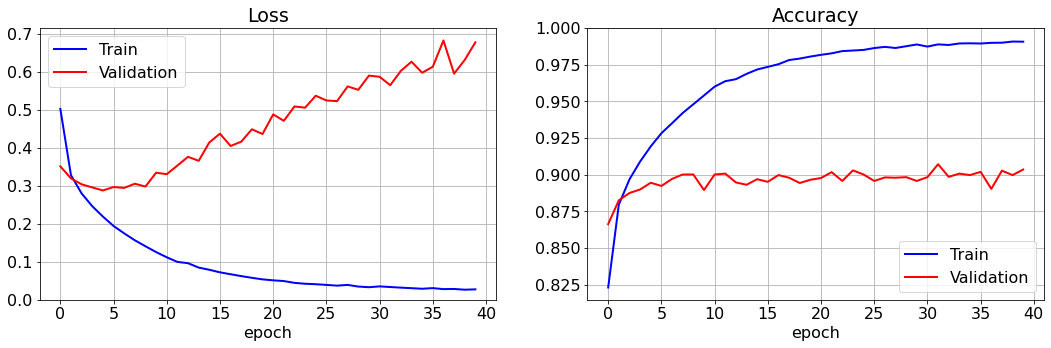

In [21]:
plt.figure(figsize=(18, 5))

plt.subplot(1,2,1)
plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
plt.plot   (vValLoss,   'r', lw=2, label='Validation')
plt.title  ('Loss')
plt.xlabel ('epoch')
plt.ylim   (bottom=0)
plt.legend ()
plt.grid   ()

plt.subplot(1,2,2)
plt.plot   (vTrainAcc, 'b', lw=2, label='Train'     )
plt.plot   (vValAcc,   'r', lw=2, label='Validation')
plt.title  ('Accuracy')
plt.xlabel ('epoch')
plt.ylim   (top=1)
plt.legend ()
plt.grid   ()